### В данной домашней работе Вам предстоит отработать следующие 2 навыка: работа с пропущенными значениями и анализ выбросов.

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('processed_data_with_new_features.csv', index_col='id')

In [2]:
data.head()

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,anomaly,traffic_jam,day_of_week_1,day_of_week_2,day_of_week_3,...,hour_19,hour_20,hour_21,hour_22,hour_23,month_2,month_3,month_4,month_5,month_6
id,,,,,,,,,,,,,,,,,,,,,
id2875421,1,930.399753,0,1.500479,6.122493,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
id2377394,0,930.399753,0,1.807119,6.498282,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
id3858529,1,NaN,0,6.392080,7.661527,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
id3504673,1,NaN,0,1.487155,6.063785,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
id2181028,1,930.399753,0,1.189925,6.077642,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Никудышный гном случайно пролил кофе на папку с данными и кодом. К несчастью, из-за этого они с братьями потеряли кучу информации в столбиках **passenger_count** и **distance_km**.

In [6]:
### Выведите количество пропусков в данных колонках
### На всякий случай, проверьте целостность данных в остальных

data.isna().sum()

vendor_id                  0
passenger_count       145864
store_and_fwd_flag         0
distance_km           145864
log_trip_duration          0
anomaly                    0
traffic_jam                0
day_of_week_1              0
day_of_week_2              0
day_of_week_3              0
day_of_week_4              0
day_of_week_5              0
day_of_week_6              0
hour_1                     0
hour_2                     0
hour_3                     0
hour_4                     0
hour_5                     0
hour_6                     0
hour_7                     0
hour_8                     0
hour_9                     0
hour_10                    0
hour_11                    0
hour_12                    0
hour_13                    0
hour_14                    0
hour_15                    0
hour_16                    0
hour_17                    0
hour_18                    0
hour_19                    0
hour_20                    0
hour_21                    0
hour_22       

Начнем с **passenger_count**. Вообще говоря, изначально это была категориальная колонка, к которой мы применили технику OneHotEncoder. Чтобы избавиться от пропусков в данных, конечно, можно просто убрать все объекты, в которых есть пропуски, но тогда мы потеряем ценную информацию. 

Воспользуйтесь относительно простым приемом из лекции: в указанной колонке заполните пропуски самым *популярным* значением среди неотсутствующих.

In [15]:
mode_passenger = data['passenger_count'].mode()[0]
data['passenger_count'] = data['passenger_count'].fillna(mode_passenger)
mode_passenger

930.3997532751514

С колонкой **distance_km** поступим более интересным способом!

Чтобы заполнить пропуск в данной колонке для того или иного объекта, можно находить наиболее похожий на него объект и подглядывать в его значение **distance_km**. Для того, чтобы понять, насколько объекты похожи друг на друга, необходимо использовать Евклидово расстояние между этими самыми объектами в пространстве всех признаков!

С учетом количества объектов в нашем датасете и признаков, посчитать попарные расстояния будет мега-сложно. Поэтому давайте называть объекты похожими, если они принадлежат одной категории, составленной из следующих колонок:

1. vendor_id
2. store_and_fwd_flag
3. traffic_jam
4. month_2
5. month_3
6. month_4
7. month_5
8. month_6

Внутри каждой группы найдите среднее значение признака **distance_km** и заполните NaN'ы в объектах с пропуском в соответствии с тем, к какой категории относится данный объект. Похожее упражнение мы делали на практике в занятии!

**Hint**: достаточно просто взять group by по указанным выше категориальным колонкам и верно вставить полученный результат в исходную табличку.

P.S. Колонки выбраны случайным образом. Можно было взять и другую комбинацию.

In [30]:
data.shape

(1458644, 41)

In [32]:
cat_cols = ['vendor_id', 'store_and_fwd_flag', 'traffic_jam' ,'month_2' ,'month_3' ,'month_4' ,'month_5' ,'month_6']
grouped_means = data.groupby(cat_cols)['distance_km'].transform("mean")

In [33]:
data['distance_km'] = data['distance_km'].fillna(grouped_means)

In [35]:
### Убедимся, что пропусков не осталось
data.isna().sum().sum()

0

In [39]:
data_row_20 = data.iloc[:20]
data_row_20.to_csv('data_hw8.csv', sep=';', index=False)

### Теперь наши данные чисты! Замерьте качество модели на Кросс-Валидации

In [71]:
X, y = data.drop('log_trip_duration', axis=1), data['log_trip_duration']

In [72]:
from sklearn.model_selection import KFold

selector = KFold(n_splits=4, shuffle=True, random_state=33)

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

model = LinearRegression()

cv_results = cross_validate(model, X, y, cv=selector, scoring='neg_mean_squared_error')
cross_val_error = np.mean(cv_results['test_score'])

print(f"MSLE на Кросс-валидации: {round(cross_val_error, 3)}")

MSLE на Кросс-валидации: -0.431


### Проведем анализ выбросов! Нарисуйте ящик с усами и гистограмму для таргетной переменной.

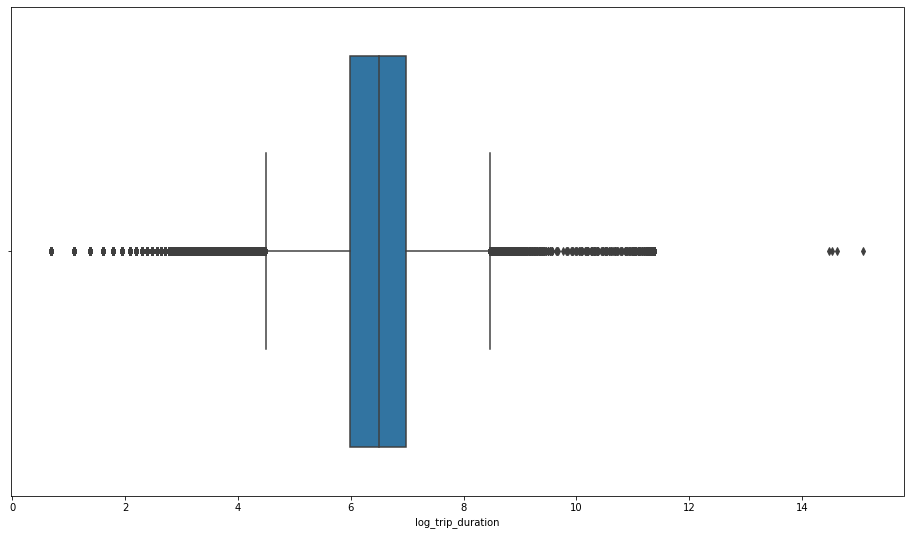

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.boxplot(x=y)
ax.figure.set_size_inches(16,9)


Есть ли, на ваш взгляд, в данных выбросы?

Кажется, что да!

Давайте почистим их, удалив не объекты, таргеты которых находятся вне промежутка

[топ 99,5% значение;   топ 0,5% значение]

In [97]:
### Your code is here
### Расчитаем длину усиков
upper_tentacle = data['log_trip_duration'].quantile(0.995)
lower_tentacle = data['log_trip_duration'].quantile(0.005)

In [98]:
df = data[(data['log_trip_duration']<upper_tentacle) & (data['log_trip_duration']>lower_tentacle)]

Снова замерьте качество на кросс-валидации, используя старый selector

In [99]:
### Your code is here
X, y = df.drop('log_trip_duration', axis=1), df['log_trip_duration']

model = LinearRegression()

cv_results = cross_validate(model, X, y, cv=selector, scoring='neg_mean_squared_error')
cross_val_error = np.mean(cv_results['test_score'])

print(f"MSLE на Кросс-валидации: {round(cross_val_error, 3)}")

MSLE на Кросс-валидации: -0.35
